In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np
# import PIL

In [25]:
# location to the dataset
data_dir = 'dataset'

In [26]:
# Hyperparameters
BATCHSIZE = 32
IMAGE_SIZE = 180 # h, w
EPOCHS =20

In [27]:
# loading the Train dataset 
train_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset ='training',
    seed = 123,
    image_size =(IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCHSIZE
)

Found 7193 files belonging to 5 classes.
Using 5755 files for training.


In [29]:
# loading the validation dataset 
val_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split =0.2,
    subset = 'validation',
    seed = 123,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCHSIZE
)

Found 7193 files belonging to 5 classes.
Using 1438 files for validation.


In [30]:
class_names = train_ds.class_names
print(class_names)

['Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy']


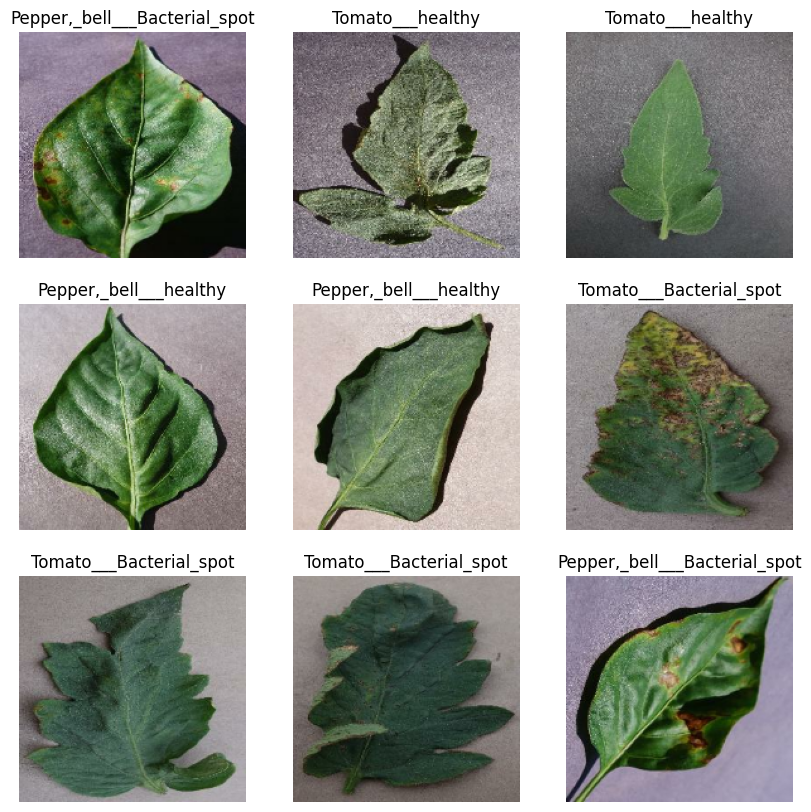

In [31]:
#visualization
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [32]:
for image_batch, label_batch in train_ds:
    print(image_batch.shape)
    print(label_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [13]:
# Configure the dataset for performance
train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

In [33]:
# [0, 255]
# [0, 1]
normalizations_layers = layers.Rescaling(1./255)

In [34]:
normalize_ds = train_ds.map(lambda x, y: (normalizations_layers(x), y))
image_batch, label_batch = next(iter(normalize_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.9765761


In [35]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(IMAGE_SIZE,
                                  IMAGE_SIZE,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [36]:
# Loading the  Mobile Net V2 model
mobilenetv2_base = keras.applications.mobilenet_v2.MobileNetV2(
    weights = 'imagenet',
    include_top = False 
)

In [38]:
mobilenetv2_base.trainable = False

In [39]:
inputs = keras.Input(shape = (IMAGE_SIZE,IMAGE_SIZE, 3 ))
x = data_augmentation(inputs)
x = keras.applications.mobilenet_v2.preprocess_input(x)
x = mobilenetv2_base(x)
x = layers.Flatten()(x)
x = layers.Dense(512)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation = keras.activations.softmax)(x)
model = keras.Model(inputs, outputs)

In [40]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 180, 180, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 180, 180, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                                           

In [41]:
model.compile(
    loss= keras.losses.SparseCategoricalCrossentropy(),
    optimizer = keras.optimizers.RMSprop(),
    metrics = ['accuracy']
    )


In [42]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = f'plant_model_mobilenetV2.h5',
        save_best_only = True,
        monitor='val_loss'
    )
]

In [43]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    validation_data = val_ds,
    callbacks = callbacks
)

Epoch 1/20
180/180 [==============================] - 191s 900ms/step - loss: 23.6329 - accuracy: 0.8212 - val_loss: 3.4651 - val_accuracy: 0.9576
Epoch 2/20
180/180 [==============================] - 135s 750ms/step - loss: 7.2797 - accuracy: 0.9159 - val_loss: 10.5653 - val_accuracy: 0.9117
Epoch 3/20
180/180 [==============================] - 130s 720ms/step - loss: 6.4541 - accuracy: 0.9354 - val_loss: 17.5230 - val_accuracy: 0.8908
Epoch 4/20
180/180 [==============================] - 129s 715ms/step - loss: 4.9728 - accuracy: 0.9414 - val_loss: 3.4951 - val_accuracy: 0.9611
Epoch 5/20
180/180 [==============================] - 131s 725ms/step - loss: 5.0906 - accuracy: 0.9482 - val_loss: 3.4015 - val_accuracy: 0.9659
Epoch 6/20
180/180 [==============================] - 128s 711ms/step - loss: 4.7218 - accuracy: 0.9522 - val_loss: 4.1599 - val_accuracy: 0.9527
Epoch 7/20
180/180 [==============================] - 128s 710ms/step - loss: 3.9360 - accuracy: 0.9581 - val_loss: 6.987

In [44]:
model.save("plant_models.h5")

In [45]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('plant_modelH5.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\winsweb\AppData\Local\Temp\tmpif_i_xqz\assets


INFO:tensorflow:Assets written to: C:\Users\winsweb\AppData\Local\Temp\tmpif_i_xqz\assets


In [48]:
test_ds = keras.utils.image_dataset_from_directory(
    'test_ds',
    seed = 123,
    image_size =(IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCHSIZE
)

Found 775 files belonging to 5 classes.


In [49]:
scores = model.evaluate(test_ds)

25/25 [==============================] - 2s 56ms/step - loss: 2.5775 - accuracy: 0.9806


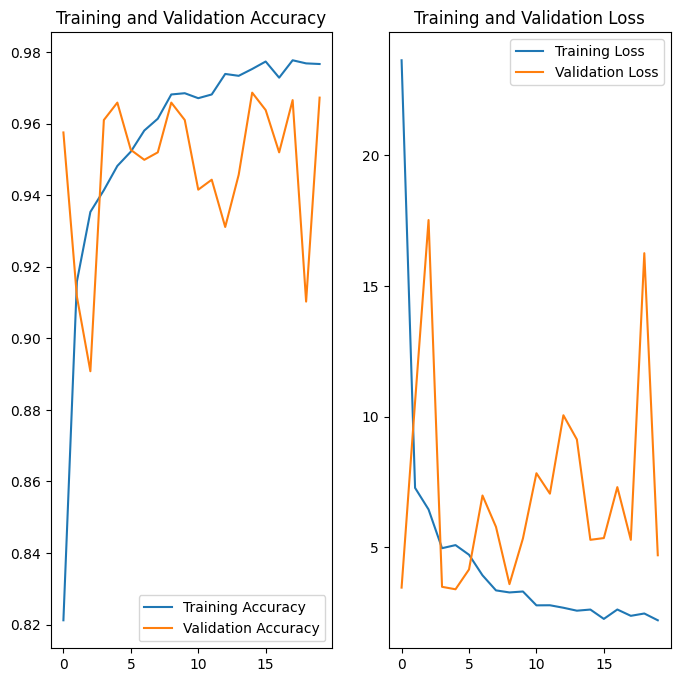

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [52]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")